In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy
import pywt
from pathlib import Path
from IPython.display import clear_output
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.optimize import minimize
from scipy.signal import stft
from scipy.signal import iirnotch, lfilter, freqz

In [ ]:
#--------------------------------
PERSON_NUMBER=1
#--------------------------------

In [ ]:
def ReadRawData(pathFile):
    arrays = []
    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [ ]:
def ReadPapaerEst(pathFile):
    arrays = []
    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        
        for value in lines:
            arrays.append(float(value.strip()))
    return arrays

In [ ]:
def ReadRefData(pathFile):
    beat_file =open(pathFile)
    beats = [float(br)for br in beat_file.read().split(",")]
    return beats

In [ ]:
def genetate3DAmplitudeRangeMap(amplitudeRangeMap,title,elev,azim):
    
    num_range_profile =amplitudeRangeMap.shape[0]
    range_profile_len =amplitudeRangeMap.shape[1]
    
    # Create grid for 3D plotting
    x = np.arange(num_range_profile)
    tmp=np.arange(range_profile_len)
    y = 2*tmp[:range_profile_len//2]

    x, y = np.meshgrid(x, y)

    # Magnitude of the FFT components for the first half of the frequencies
    fft_magnitude = amplitudeRangeMap[:, :range_profile_len//2]
    
    # Plotting
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the 3D surface
    ax.plot_surface(x, y, fft_magnitude.T, cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel('Slow - time')
    ax.set_ylabel('Fast - time')
    ax.set_zlabel('Amblitude')
    ax.view_init(elev=elev, azim=azim)  # Change the angles as desired
    plt.show()


In [ ]:
def filter_signal (signal_to_filter ,low_freq,high_freq,sampling_rate,filter_order):
    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [ ]:
def MAPE(true_signal,ref_signal):
    true_array=np.array(true_signal)
    ref_array=np.array(ref_signal)
    return np.mean(np.abs((true_array - ref_array) / true_array))
    

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

def RPD(y_true, y_pred):
    return (np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2)))/np.sqrt(np.mean((np.array(y_true) ) ** 2))
    
    

In [ ]:
def moving_average(data, window_size, slide):
    filtered_data = []
    filtered_data=[data[0]]*(window_size-1)
    for i in range(0, len(data) - window_size + 1, slide):
        window = data[i:i + window_size]
        average = sum(window) / window_size
        filtered_data.append(average)
    return filtered_data

In [ ]:
def extract_phase_DACM(complex_signals):
    phases=[]
    phases.append(np.angle(complex_signals[0]))

    for s in range(1,len(complex_signals)):
        phase_s=0
        for k in range(1,s):
            I_k =complex_signals[k].real
            Q_k=complex_signals[k].imag
            I_k_1=complex_signals[k-1].real
            Q_k_1=complex_signals[k-1].imag
            phase_s+=(I_k*(Q_k-Q_k_1) - (I_k -I_k_1)*Q_k)/(I_k**2 +Q_k**2)
        phases.append(phase_s)
    return phases


In [ ]:
def DCCompensation(inputData):
    
  X=np.real(inputData)
  Y=np.imag(inputData)

  A=np.column_stack((2*X ,2*Y, np.ones(X.shape)))
  B=X**2 +Y**2

  # Step 1: Compute A^T A
  ATA = np.dot(A.T, A)

  try:
      # Step 2: Compute the inverse of A^T A
    ATA_inv = np.linalg.inv(ATA)
  except Exception as e:
    print("An error occurred:", e)
      
  finally:
    print("")

  # Step 2: Compute the inverse of A^T A
  ATA_inv = np.linalg.inv(ATA)

  # Step 3: Compute A^T B
  ATB = np.dot(A.T, B)


  # Step 4: Compute the solution (x) using the formula (A^T A)^-1 A^T B
  a,b,c = np.dot(ATA_inv, ATB)
  r = np.sqrt(a**2 + b**2 + c)
  print("Center of the circle: (", a, ",", b, ")")
  print("Radius of the circle:", r)
  # Calculate the radius
  
  return a, b, r
  

In [ ]:
def moving_average_filter(input_data,window_size=5,sliding_size=1):
    retdata =[]    
    data_size = len(input_data)
    for jj in range(0,window_size-1):
        retdata.append(input_data[jj])
    start_index =0
    while start_index < data_size -window_size:
        average_value =np.average(input_data[start_index:start_index+window_size])
        retdata.append(average_value)
        start_index+=sliding_size  
    return retdata

In [ ]:
def getWindowFreq(signal_window,rate_of_sampling):
    fft_result = np.fft.fft(signal_window)
    freqs = np.fft.fftfreq(len(signal_window), 1 / (rate_of_sampling*60))
    dominant_frequency = np.abs(freqs[np.argmax(np.abs(fft_result))])
    return dominant_frequency

In [ ]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**8
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 256
Range resolution 0.04
Range bin 0.04303617205204089
Max range 11.017260045322468


In [4191]:

raw_datas=[]
breath_est_papers=[]
heart_est_papers=[]
breaths=[]
hearts=[]
for i in range(1,51):
    # file_path = 'FMCW Radar/Rawdata/Rawdata_{0}.csv'.format(PERSON_NUMBER)
    # raw_data = ReadRawData(file_path)
    # breath_est_paper=ReadPapaerEst("FMCW Radar/Heart Rate & Breathing Rate/Breath_{0}.csv".format(PERSON_NUMBER))
    # heart_est_paper=ReadPapaerEst("FMCW Radar/Heart Rate & Breathing Rate/Heart_{0}.csv".format(PERSON_NUMBER))
    # breath=ReadRefData("Nihon Kohden/Heart Rate & Breathing Rate/Ref_Breath_{0}.csv".format(PERSON_NUMBER))
    # heart=ReadRefData("Nihon Kohden/Heart Rate & Breathing Rate/Ref_Heart_{0}.csv".format(PERSON_NUMBER))
    file_path = 'FMCW Radar/Rawdata/Rawdata_{0}.csv'.format(i)
    raw_datas.append(ReadRawData(file_path))
    breath_est_papers.append(ReadPapaerEst("FMCW Radar/Heart Rate & Breathing Rate/Breath_{0}.csv".format(i)))
    heart_est_papers.append(ReadPapaerEst("FMCW Radar/Heart Rate & Breathing Rate/Heart_{0}.csv".format(i)))
    breaths.append(ReadRefData("Nihon Kohden/Heart Rate & Breathing Rate/Ref_Breath_{0}.csv".format(i)))
    hearts.append(ReadRefData("Nihon Kohden/Heart Rate & Breathing Rate/Ref_Heart_{0}.csv".format(i)))
    


In [10597]:
filename_unwrap_breath ="unwrap_breath.txt"
filename_unwrap_heart ="unwrap_heart.txt"
filename_linenear_breath ="linear_breath.txt"
filename_linenear_heart ="linear_heart.txt"
filename_paper_breath="papaer_breath.txt"
filename_paper__heart="papaer_heart.txt"
PERSON=1+PERSON
#EST_TYPE=0#unwrap
EST_TYPE=1#linear
#EST_TYPE=2#gradient

PERSON_NUMBER=PERSON
raw_data=raw_datas[PERSON]
breath_est_paper=breath_est_papers[PERSON]
heart_est_paper=heart_est_papers[PERSON]
breath =breaths[PERSON]
heart =hearts[PERSON]
print(PERSON)

10


In [10598]:
BR_LO=np.min(breath)/60
BR_HI=np.max(breath)/60

HR_LO=np.min(heart)/60
HR_HI=np.max(heart)/60
print(np.min(heart))
print(np.max(heart))
EST_WIN_SIZE_HEART=8#10 second
EST_WIN_SIZE_BREATH=10

81.0
105.0


In [10599]:
df = pd.read_excel("Participant/Human Data/HumanData.xlsx", header=None)  # assuming no header present
df_transposed = df.transpose()
columnNames =[rows[0] for rows in df_transposed.iloc]
participants =[]
df_transposed = df.transpose()
df_transposed = df_transposed[1:]
for p in range(1,df_transposed.shape[1]):
    participants.append([v for v in df_transposed[p]])

# participant="Participant #{0},{1},Age={2} month ({3} cms) ({4} kgs)  ({5} bmp) ({6} bmp)".format(PERSON_NUMBER,
participant="Participant #{0},{1},Age={2} months".format(PERSON_NUMBER,
    participants[PERSON_NUMBER-1][0],participants[PERSON_NUMBER-1][1],
    participants[PERSON_NUMBER-1][2],participants[PERSON_NUMBER-1][3],
    participants[PERSON_NUMBER-1][6],participants[PERSON_NUMBER-1][7])

In [10600]:
print(raw_data.shape)
estChannel=raw_data[0]
estChannelLen=len(estChannel)
print(estChannelLen)
dataIndex =0
chirps=[]
while dataIndex<estChannelLen:
    chirps.append(estChannel[dataIndex:dataIndex+SAMPLE_PER_CHIRP])
    dataIndex +=SAMPLE_PER_CHIRP
print(np.array(chirps).shape)

(4, 3072000)
3072000
(12000, 256)


In [10601]:
eveluate_channels =[]
for tmp_channel in  raw_data:
    eveluate_channels.append(np.array([tmp_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)]))

In [10602]:
range_for_plotting =range(1,FFT_SIZE,2**4)
range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]
origin_channel=np.array(eveluate_channels[0])

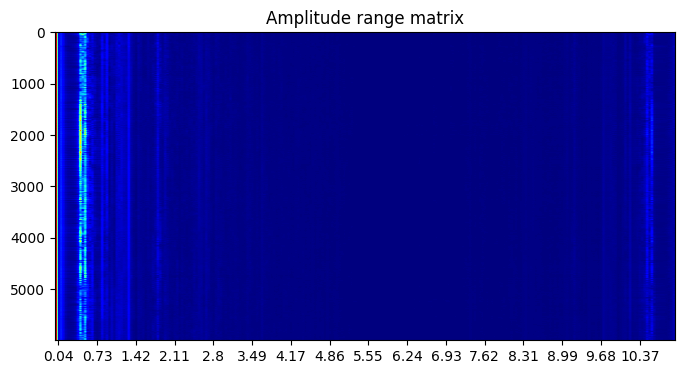

In [10603]:
plt.figure(figsize=(8,4))
plt.imshow(np.abs(np.fft.fft(origin_channel,axis=1)),cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.title("Amplitude range matrix")
plt.show()

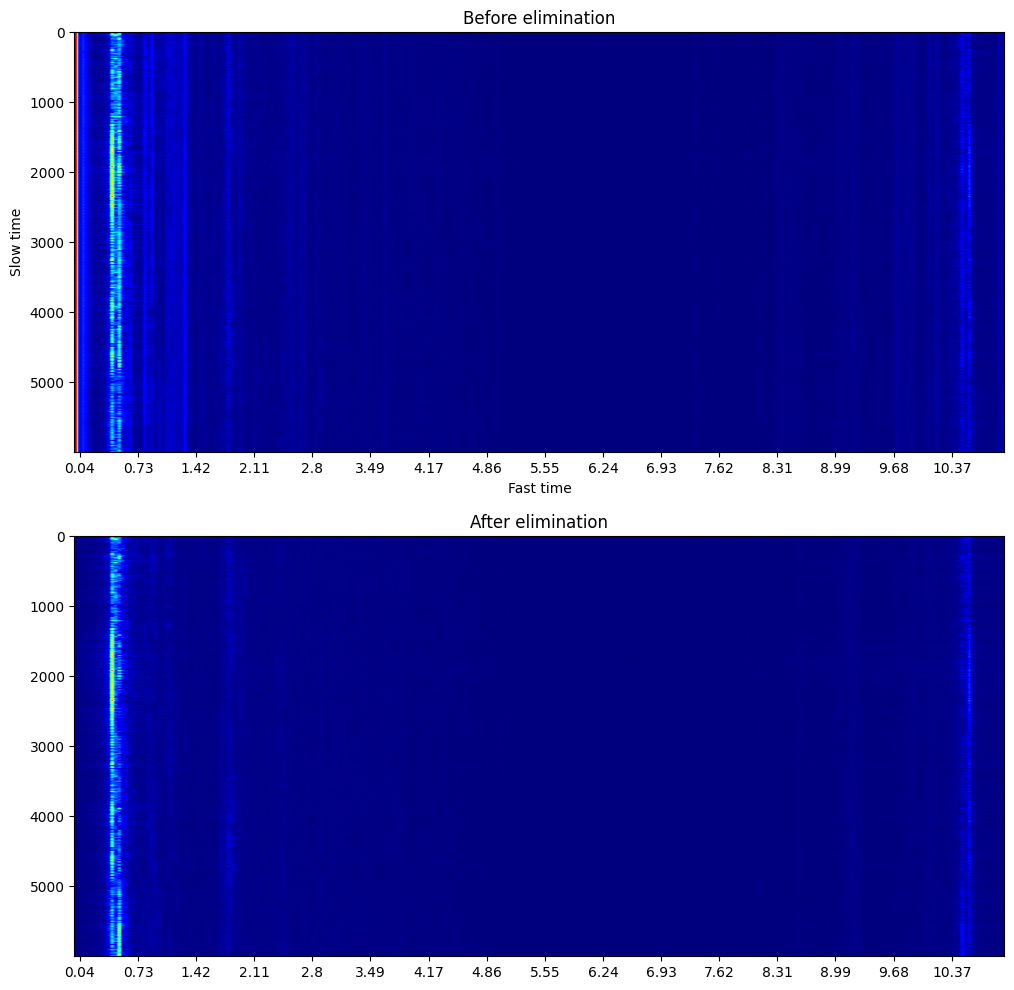

In [10604]:

eliminated_est_channel=np.zeros_like(origin_channel)
for i in range(0,origin_channel.shape[1]):
    eliminated_est_channel[:,i] =origin_channel[:,i] - np.mean(origin_channel[:,i])


origin_amplitude =np.abs(np.fft.fft(origin_channel,axis=1))
eliminated_amplitude =np.abs(np.fft.fft(eliminated_est_channel,axis=1))
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
plt.imshow(origin_amplitude,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.xlabel("Fast time")
plt.ylabel("Slow time")
plt.title("Before elimination")

plt.subplot(2,1,2)
plt.imshow(eliminated_amplitude,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)

plt.title("After elimination")

plt.show()


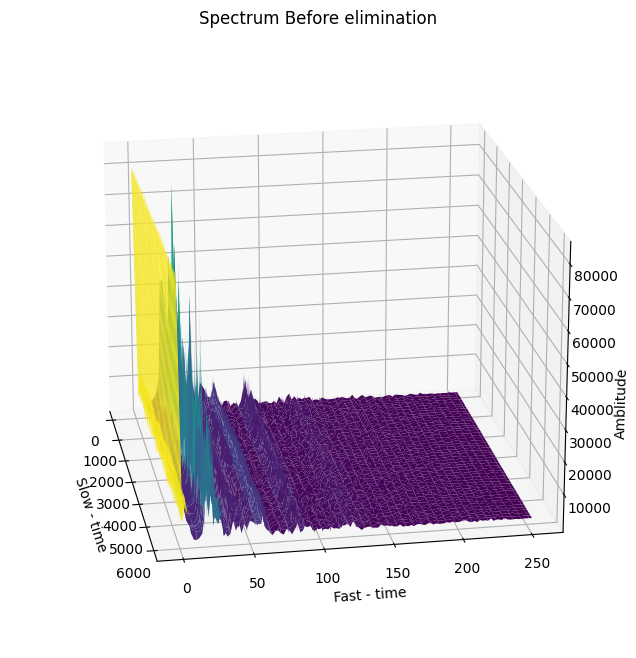

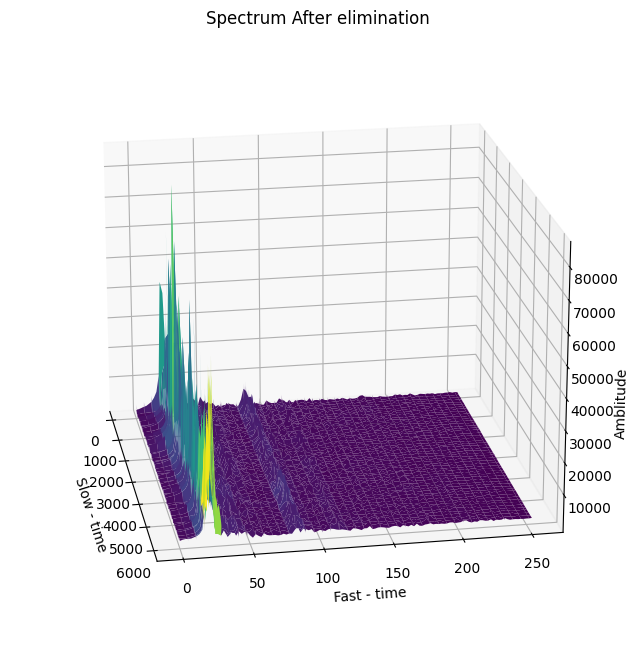

In [10605]:
genetate3DAmplitudeRangeMap(origin_amplitude,'Spectrum Before elimination',20,-10)
genetate3DAmplitudeRangeMap(eliminated_amplitude,'Spectrum After elimination',20,-10)

In [10606]:
sumAmplitude=[]
for i in range(0,eliminated_amplitude.shape[1]):
  sumAmplitude.append(np.sum(eliminated_amplitude[:,i]))
binToSelect =np.argmax(sumAmplitude)
print(binToSelect)

10


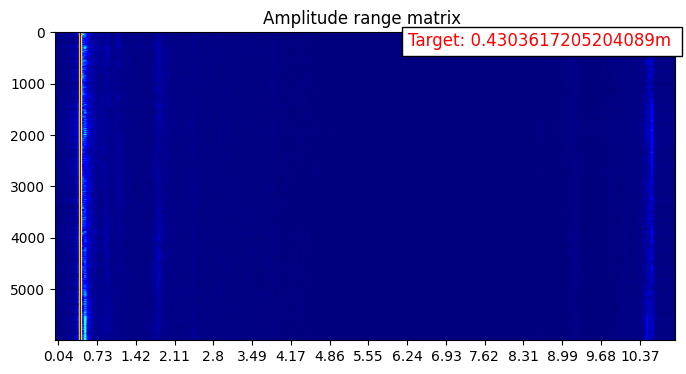

In [10607]:

tmp_amplitude_range_matrix=np.abs(eliminated_amplitude)
tmp_amplitude_range_matrix[:,binToSelect]=99999
plt.figure(figsize=(8,4))
plt.imshow(tmp_amplitude_range_matrix,cmap='jet',aspect='auto')
plt.xticks(range_for_plotting, range_bin_distance)
plt.text(tmp_amplitude_range_matrix.shape[1], 0, 'Target: {0}m '.format(binToSelect*RANGE_BIN), fontsize=12, color='red',
         horizontalalignment='right', verticalalignment='top',
         bbox=dict(facecolor='white', alpha=1))

plt.title("Amplitude range matrix ")
plt.show()

In [10608]:
est_bin_data=(np.array(origin_channel[:,binToSelect])).flatten()

In [10609]:

est_bin_data_real = [num.real for num in est_bin_data]
est_bin_data_image =[num.imag for num in est_bin_data]

Iteration 0, Loss: 546514692.790084, h: -2.0717, k: -1.2314, r: 7.3037
Iteration 100, Loss: 46935410.140429, h: -129.0917, k: -101.0680, r: 153.8880
Iteration 200, Loss: 36776164.565922, h: -155.9851, k: -130.1043, r: 144.8917
Iteration 300, Loss: 31027612.314947, h: -177.4584, k: -149.0048, r: 133.4472
Iteration 400, Loss: 28416903.409971, h: -194.0056, k: -159.5520, r: 126.9547
Iteration 500, Loss: 27333279.193397, h: -206.1105, k: -164.1843, r: 123.8670
Iteration 600, Loss: 26868642.813482, h: -214.6509, k: -165.2546, r: 122.4767
Iteration 700, Loss: 26651386.172145, h: -220.5508, k: -164.4719, r: 121.8713


Iteration 800, Loss: 26519058.196750, h: -224.9623, k: -162.9081, r: 121.6293
Iteration 900, Loss: 26421981.807209, h: -228.5685, k: -161.1348, r: 121.5815


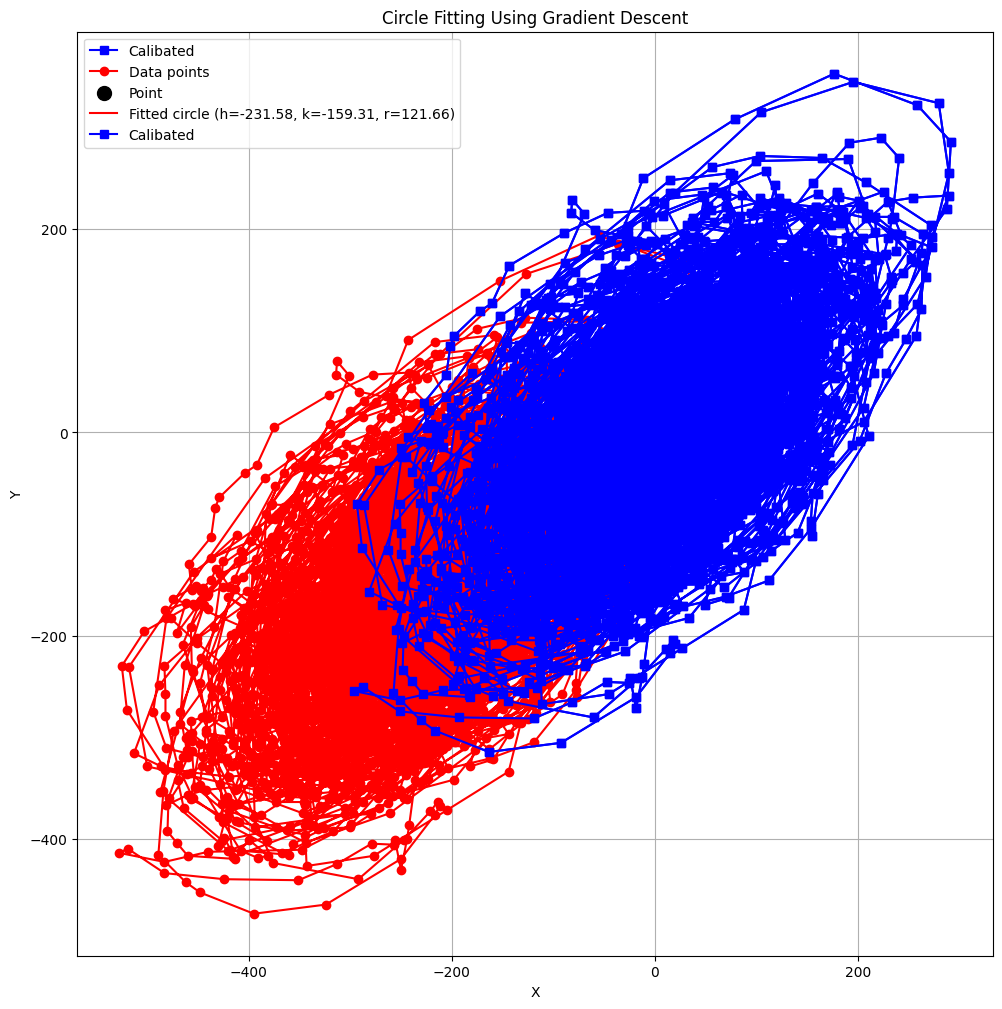

Tâm của đường tròn: h = -231.57592877129056, k = -159.30549139958094
Bán kính của đường tròn: r = 121.6551180277623


In [10610]:

# Dữ liệu điểm (x, y)
x_data_example = np.array(est_bin_data_real)
y_data_example = np.array(est_bin_data_image)

# Hàm tính tổng bình phương sai số
def compute_loss(h, k, r, x, y):
    return np.sum((np.sqrt((x - h) ** 2 + (y - k) ** 2) - r) ** 2)

# Hàm tính gradient của hàm sai số
def compute_gradient(h, k, r, x, y):
    n = len(x)
    dL_dh = np.sum(2 * (np.sqrt((x - h) ** 2 + (y - k) ** 2) - r) * (h - x) / np.sqrt((x - h) ** 2 + (y - k) ** 2))
    dL_dk = np.sum(2 * (np.sqrt((x - h) ** 2 + (y - k) ** 2) - r) * (k - y) / np.sqrt((x - h) ** 2 + (y - k) ** 2))
    dL_dr = -2 * np.sum(np.sqrt((x - h) ** 2 + (y - k) ** 2) - r)
    return dL_dh / n, dL_dk / n, dL_dr / n

# Gradient Descent
def gradient_descent(x, y, h_init, k_init, r_init, learning_rate=0.01, num_iterations=1000):
    h, k, r = h_init, k_init, r_init
    for i in range(num_iterations):
        # Tính gradient
        dL_dh, dL_dk, dL_dr = compute_gradient(h, k, r, x, y)
        
        # Cập nhật tham số
        h -= learning_rate * dL_dh
        k -= learning_rate * dL_dk
        r -= learning_rate * dL_dr
        
        # In ra giá trị lỗi mỗi 100 lần lặp
        if i % 100 == 0:
            loss = compute_loss(h, k, r, x, y)
            print(f"Iteration {i}, Loss: {loss:.6f}, h: {h:.4f}, k: {k:.4f}, r: {r:.4f}")
    
    return h, k, r

# Giá trị khởi tạo
h_init, k_init, r_init = 2.5, 2.0, 1.5

# Thực hiện gradient descent
h_opt_gd, k_opt_gd, r_opt_gd = gradient_descent(x_data_example, y_data_example, h_init, k_init, r_init, learning_rate=0.01, num_iterations=1000)

# Vẽ biểu đồ
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = h_opt_gd + r_opt_gd * np.cos(theta)
circle_y = k_opt_gd + r_opt_gd * np.sin(theta)



est_bin_data_gradient_compensated =est_bin_data - complex(h_opt_gd,k_opt_gd)

est_gradient_compensation  =(np.array(est_bin_data_gradient_compensated).flatten()) 
est_bin_data_gradient_compensated_real = [num.real for num in est_gradient_compensation]
est_bin_data_gradient_compensated_image =[num.imag for num in est_gradient_compensation]

plt.figure(figsize=(12, 12))
plt.plot(est_bin_data_gradient_compensated_real, est_bin_data_gradient_compensated_image, 'bs-',label="Calibated")

plt.plot(x_data_example, y_data_example,  color='red', marker='o', label='Data points')  # Dữ liệu điểm
plt.scatter(h_opt_gd, k_opt_gd, color='black', marker='o', label='Point',s=100)
plt.plot(circle_x, circle_y, 'r-', label=f'Fitted circle (h={h_opt_gd:.2f}, k={k_opt_gd:.2f}, r={r_opt_gd:.2f})')  # Đường tròn khớp
plt.plot(est_bin_data_gradient_compensated_real, est_bin_data_gradient_compensated_image, 'bs-',label="Calibated")

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

plt.title('Circle Fitting Using Gradient Descent')
plt.grid(True)
plt.show()

# In ra kết quả cuối cùng
print(f"Tâm của đường tròn: h = {h_opt_gd}, k = {k_opt_gd}")
print(f"Bán kính của đường tròn: r = {r_opt_gd}")

In [10611]:
a,b,r=DCCompensation(est_bin_data)
print(f"{a} {b} {r}")


Center of the circle: ( -236.48195399323868 , -153.9184070784962 )
Radius of the circle: 138.96892022912644
-236.48195399323868 -153.9184070784962 138.96892022912644


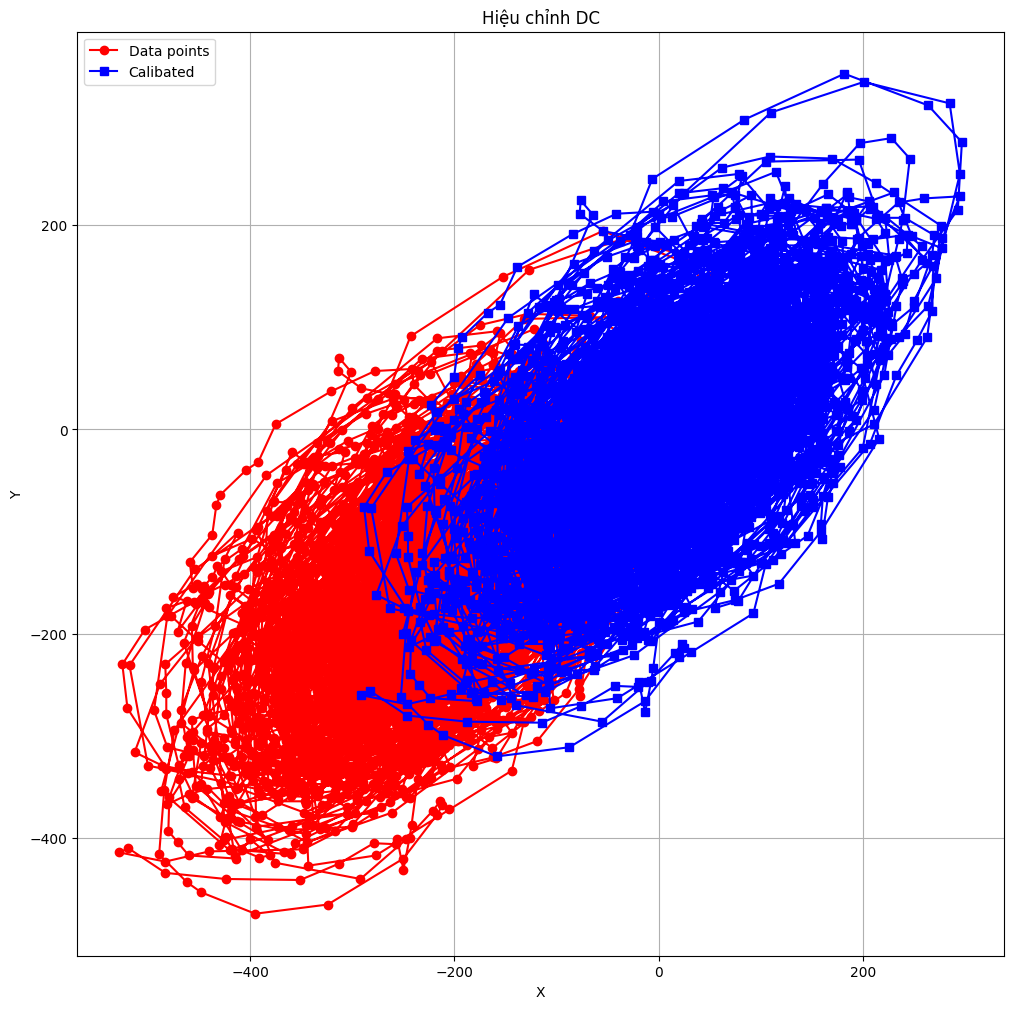

In [10669]:

est_bin_data_linear_compensated =est_bin_data - complex(a,b)

est_linear_compensation  =(np.array(est_bin_data_linear_compensated).flatten()) 
est_bin_data_linear_compensated_real = [num.real for num in est_linear_compensation]
est_bin_data_linear_compensated_image =[num.imag for num in est_linear_compensation]
plt.figure(figsize=(12, 12))

plt.plot(x_data_example, y_data_example,  color='red', marker='o', label='Data points')  # Dữ liệu điểm

plt.plot(est_bin_data_linear_compensated_real, est_bin_data_linear_compensated_image, 'bs-',label="Calibated")

plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

plt.title('Hiệu chỉnh DC')
plt.savefig("hieuchinhdc.png")
plt.grid(True)
plt.show()



In [10613]:

# plt.plot(unwrapped_signal,color="red",linestyle="-")
# plt.title("Not compensate")
# plt.show()

In [10614]:
unwrapped_signal             =(np.unwrap(np.angle(est_bin_data)))
unwrapped_signal_linear =(np.unwrap(np.angle(est_bin_data_linear_compensated)))
unwrapped_signal_gradient =(np.unwrap(np.angle(est_bin_data_gradient_compensated)))
#compensated_unwrapped_signal =(np.unwrap(np.angle(est_bin_data_linear_compensated)))
# plt.plot(compensated_unwrapped_signal,color="blue",linestyle="-")
# plt.title("Compensate")
# plt.show()

In [10615]:
diff_unwrapped_signal =np.diff(np.unwrap(np.angle(est_bin_data)))
# plt.plot(diff_unwrapped_signal,color="red",linestyle="-")
# plt.title("Not compensate with DIFF")
# plt.show()

In [10616]:
diff_compensated_unwrapped_signal =np.diff(np.unwrap(np.angle(est_bin_data)))
# plt.plot(diff_compensated_unwrapped_signal,color="blue",linestyle="-")
# plt.title("Compensate with DIFF")
# plt.show()

In [10617]:

if 0==EST_TYPE:
    signal_2_estimate =unwrapped_signal
if 1 ==EST_TYPE:
    signal_2_estimate =unwrapped_signal_linear
if 2==EST_TYPE:
    signal_2_estimate =unwrapped_signal_gradient


In [10618]:
START_SIGNAL=20
END_SIGNAL=260

In [10619]:
def estimateFreq(signal_for_est):
    initDuration=5
    sampling_rate=20
    window_size= initDuration*sampling_rate
    
    freq_peaks=[0]*(initDuration-1)
    overlap=20
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        windowFreq=getWindowFreq(window_signal,sampling_rate)
        freq_peaks.append(windowFreq)
        start_idx += overlap
    
    return freq_peaks

In [10620]:
from typing import List

def kalmanFilter(beatArray:List):
    NOISE_PROCESS =0.08
    npBeat =np.array(beatArray)
    meanBeat=npBeat.mean()
    varianceNoise =np.array([ (beat -meanBeat)**2  for beat in beatArray]).mean()
    errorCovariance=0.0
    lastErrorCovariance =0.5
    estimatedBeat =meanBeat
    for b in beatArray:
        kGain =lastErrorCovariance /(lastErrorCovariance + varianceNoise)
        estimatedBeat =estimatedBeat +kGain *( b-estimatedBeat)
        errorCovariance=(1-kGain)*lastErrorCovariance
        lastErrorCovariance=errorCovariance +NOISE_PROCESS
    return estimatedBeat

In [10621]:
EXTRACT_SAMPLING_RATE=20

In [10622]:
# estimate heart with compensation and without compensation
breath_signal=filter_signal(signal_2_estimate,BR_LO,BR_HI,EXTRACT_SAMPLING_RATE,4)
scales = np.arange(1/BR_HI, 1/BR_LO,1) 
wavelet = 'morl'  # Complex Morlet wavelet
# Perform Continuous Wavelet Transform (CWT)
coefficients, frequencies = pywt.cwt(breath_signal, scales, wavelet)
conditions =(np.where((frequencies >= BR_LO) & (frequencies <=BR_HI)))
filtered = coefficients[conditions]

In [10623]:
print(coefficients.shape)

(1, 6000)


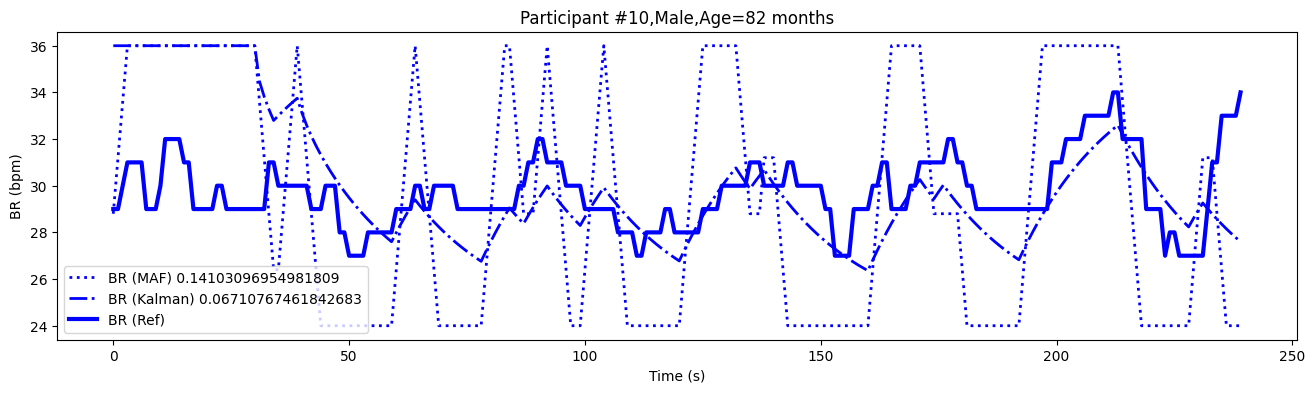

Participant #10,Male,Age=82 months


In [10624]:


for i in range(0,1):    
    rawBreathFreq =estimateFreq(filtered[i])
    breathEstMAF=moving_average_filter(rawBreathFreq)
    
    breathEstKalman=[]
    for i  in range(START_SIGNAL+1,len(rawBreathFreq)):
        breathEstKalman.append(kalmanFilter(rawBreathFreq[START_SIGNAL:i]))
    for _  in range(0,START_SIGNAL):
        breathEstKalman.insert(0,0)
  
    mape_br=MAPE(breath[START_SIGNAL:END_SIGNAL],breathEstMAF[START_SIGNAL:END_SIGNAL])
    mape_br_paper=MAPE(breath[START_SIGNAL:END_SIGNAL],breath_est_paper[START_SIGNAL:END_SIGNAL])
    mape_br_kalman=MAPE(breath[START_SIGNAL:END_SIGNAL],breathEstKalman[START_SIGNAL:END_SIGNAL])

    rpd_kalmal_br=RPD(breath[START_SIGNAL:END_SIGNAL],breathEstKalman[START_SIGNAL:END_SIGNAL])
  

    plt.figure(figsize=(16,4))

    plt.plot(breathEstMAF[START_SIGNAL:END_SIGNAL],label=f"BR (MAF) {mape_br}"
             ,color="blue",linestyle='dotted',linewidth=2)

    plt.plot(breathEstKalman[START_SIGNAL:END_SIGNAL],label=f"BR (Kalman) {mape_br_kalman}"
             ,color="blue",linestyle='-.',linewidth=2)
    
    # plt.plot(breath_est_paper[START_SIGNAL:END_SIGNAL],label=f"BR (PAPER) {mape_br}"
    #          ,color="black",linestyle='dotted',linewidth=2)

    plt.plot(breath[START_SIGNAL:END_SIGNAL],color="blue",label="BR (Ref) ",linestyle='solid',linewidth=3)
    plt.title(participant)
    plt.ylabel("BR (bpm)")
    plt.xlabel("Time (s)")

    plt.legend()
    #plt.savefig(f"figure_breath {PERSON_NUMBER}")
    plt.show()
    print(participant)


In [10625]:
# heart_signal=filter_signal((compensated_unwrapped_signal),HR_LO,HR_HI,EXTRACT_SAMPLING_RATE,2)
heart_signal=filter_signal((signal_2_estimate),HR_LO,HR_HI,EXTRACT_SAMPLING_RATE,1)

scales = np.arange(1/HR_HI, 1/HR_LO,0.1) 
print(scales)
wavelet = 'mexh'  # Complex Morlet wavelet
# Perform Continuous Wavelet Transform (CWT)
heartCoefficients, frequencies = pywt.cwt(heart_signal, scales, wavelet)
conditions =(np.where((frequencies >= HR_LO) & (frequencies <= HR_HI)))

# heartFiltered = heartCoefficients[conditions]
heartFiltered = heartCoefficients

[0.57142857 0.67142857]


In [10626]:
def estimateHeartFreq(signal_for_est):
    initDuration=5
    sampling_rate=20
    window_size= initDuration*sampling_rate
    
    freq_peaks=[0]*(initDuration-1)
    overlap=20
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        windowFreq=getWindowFreq(window_signal,sampling_rate)
        freq_peaks.append(windowFreq)
        start_idx += overlap
    
    return freq_peaks

0.05977757264273576


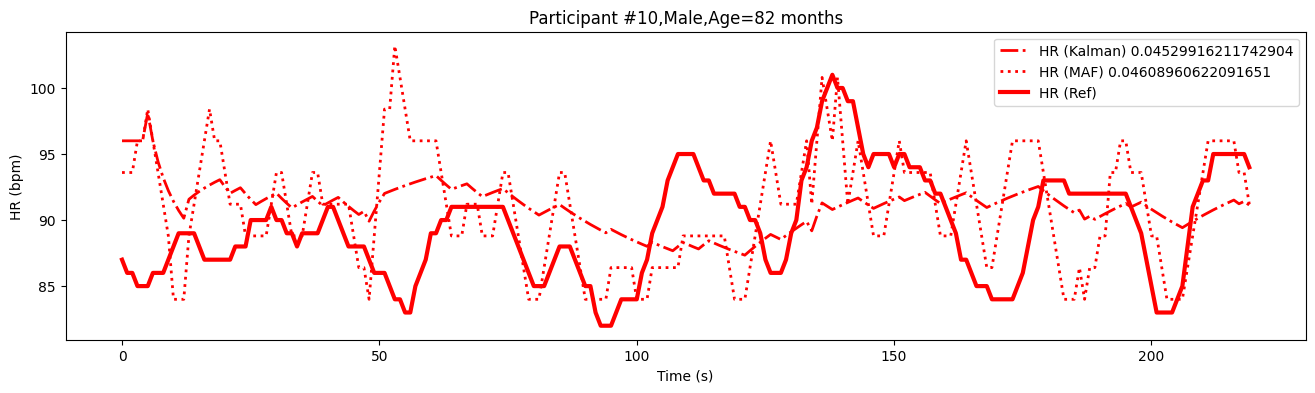

Participant #10,Male,Age=82 months


In [10627]:
START_SIGNAL=40
END_SIGNAL=260
for i in range(1,2):

    rawHeartFreq= estimateHeartFreq(heart_signal)
    heartFreq=moving_average_filter(rawHeartFreq)

    kalmanHeart=[]
    for i  in range(START_SIGNAL+1,len(rawHeartFreq)):
        kalmanHeart.append(kalmanFilter(rawHeartFreq[START_SIGNAL:i]))
    for _  in range(0,START_SIGNAL):
        kalmanHeart.insert(0,0)
  
    mape_hr_kalman=MAPE(heart[START_SIGNAL:END_SIGNAL],kalmanHeart[START_SIGNAL:END_SIGNAL])
    mape_hr_paper=MAPE(heart[START_SIGNAL:END_SIGNAL],heart_est_paper[START_SIGNAL:END_SIGNAL])
    mape_hr=MAPE(heart[START_SIGNAL:END_SIGNAL],heartFreq[START_SIGNAL:END_SIGNAL])
    rpd_hr=RPD(heart[START_SIGNAL:END_SIGNAL],heartFreq[START_SIGNAL:END_SIGNAL])
    print(rpd_hr)

    plt.figure(figsize=(16,4))
    
    plt.plot(kalmanHeart[START_SIGNAL:END_SIGNAL],label=f"HR (Kalman) {mape_hr_kalman}"
             ,color="red",linestyle='-.',linewidth=2)
   
    plt.plot(heartFreq[START_SIGNAL:END_SIGNAL],label=f"HR (MAF) {mape_hr}"
             ,color="red",linestyle='dotted',linewidth=2)

    # plt.plot(heart_est_paper[START_SIGNAL:END_SIGNAL],label=f"HR (PAPER)  {mape_hr_paper}",color="black",linestyle='-.',linewidth=2)
    
    plt.plot(heart[START_SIGNAL:END_SIGNAL],color="red",linestyle='solid',linewidth=3,label="HR (Ref)")
    plt.title(participant)
    plt.ylabel("HR (bpm)")
    plt.xlabel("Time (s)")

    plt.legend()
    #plt.savefig(f"figure_heart {PERSON_NUMBER}")
    plt.show()
    print(participant)
    
    

In [10628]:

# Sample data: Replace with your actual measurement data
# Example data for two methods

method1 = np.array(heart[START_SIGNAL:END_SIGNAL])
method2 = np.array(kalmanHeart[START_SIGNAL:END_SIGNAL])

# Calculate means and differences
means = np.mean([method1, method2], axis=0)
differences = method1 - method2

# Calculate mean difference (bias) and limits of agreement
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)  # Use ddof=1 for sample standard deviation
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# # Create the Bland-Altman plot
# plt.figure(figsize=(10, 6))
# plt.scatter(means, differences, color='red', alpha=0.6, label='Differences')
# plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
# plt.axhline(loa_upper, color='green', linestyle='--', label='Upper Limit of Agreement')
# plt.axhline(loa_lower, color='green', linestyle='--', label='Lower Limit of Agreement')

# # Annotate plot
# plt.xlabel('Mean of Two Methods')
# plt.ylabel('Difference Between Methods')
# plt.title('Bland-Altman Plot')
# plt.legend()
# plt.grid(True)
# plt.show()


In [10629]:


# Sample data: Replace with your actual measurement data
# Example data for two methods

method1 = np.array(breath[START_SIGNAL:END_SIGNAL])
method2 = np.array(breathEstKalman[START_SIGNAL:END_SIGNAL])

# Calculate means and differences
means = np.mean([method1, method2], axis=0)
differences = method1 - method2

# Calculate mean difference (bias) and limits of agreement
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)  # Use ddof=1 for sample standard deviation
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

# # Create the Bland-Altman plot
# plt.figure(figsize=(10, 6))
# plt.scatter(means, differences, color='blue', alpha=0.6, label='Differences')
# plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
# plt.axhline(loa_upper, color='green', linestyle='--', label='Upper Limit of Agreement')
# plt.axhline(loa_lower, color='green', linestyle='--', label='Lower Limit of Agreement')

# # Annotate plot
# plt.xlabel('Mean of Two Methods')
# plt.ylabel('Difference Between Methods')
# plt.title('Bland-Altman Plot')
# plt.legend()
# plt.grid(True)
# plt.show()


In [10630]:
import pandas as pd
import pingouin as pg

print(len(heart))
print(len(heartFreq))


EST_START=START_SIGNAL
EST_END=END_SIGNAL

# Example data: Heart rate measurements from Reference and FMCW radar over multiple time points
# Simulating data for one volunteer measured over 10 time points
data = pd.DataFrame({
    'Time': range(0, len(heart[EST_START:EST_END])),  # Time points (e.g., seconds, minutes)
    'Reference': np.array(heart[EST_START:EST_END]),  # Heart rate from clinical reference
    'Radar': np.array(heartFreq[EST_START:EST_END])       # Heart rate estimates from FMCW radar
    
    #'Radar': np.array(breath_est_paper[EST_START:EST_END])       # Heart rate estimates from FMCW radar
})

# Convert the data into long format required for ICC calculation
df_long = pd.melt(data, id_vars=['Time'], value_vars=['Reference', 'Radar'], 
                  var_name='Method', value_name='Measurement')

# Calculate ICC(3,1) to assess absolute agreement between radar and reference
icc = pg.intraclass_corr(data=df_long, targets='Time', raters='Method', ratings='Measurement')
print(icc)


300
299
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.174643  1.423194  219  220  0.004594   
1   ICC2     Single random raters  0.192708  1.504791  219  219  0.001307   
2   ICC3      Single fixed raters  0.201530  1.504791  219  219  0.001307   
3  ICC1k  Average raters absolute  0.297355  1.423194  219  220  0.004594   
4  ICC2k    Average random raters  0.323144  1.504791  219  219  0.001307   
5  ICC3k     Average fixed raters  0.335456  1.504791  219  219  0.001307   

          CI95%  
0   [0.04, 0.3]  
1  [0.07, 0.31]  
2  [0.07, 0.32]  
3  [0.08, 0.46]  
4  [0.12, 0.48]  
5  [0.13, 0.49]  


In [10631]:
import pandas as pd
import pingouin as pg

print(len(heart))
print(len(heartFreq))

# Example data: Heart rate measurements from Reference and FMCW radar over multiple time points
# Simulating data for one volunteer measured over 10 time points
data = pd.DataFrame({
    'Time': range(0, len(breath[EST_START:EST_END])),  # Time points (e.g., seconds, minutes)
    'Reference': np.array(breath[EST_START:EST_END]),  # Heart rate from clinical reference
    #'Radar': np.array(breathEstMAF[EST_START+2:EST_END+2])       # Heart rate estimates from FMCW radar
    'Radar': np.array(breathEstMAF[EST_START+2:EST_END+2])       # Heart rate estimates from FMCW radar
    #'Radar': np.array(breath_est_paper[EST_START:EST_END])       # Heart rate estimates from FMCW radar
})

# Convert the data into long format required for ICC calculation
df_long = pd.melt(data, id_vars=['Time'], value_vars=['Reference', 'Radar'], 
                  var_name='Method', value_name='Measurement')
# Calculate ICC(3,1) to assess absolute agreement between radar and reference

icc = pg.intraclass_corr(data=df_long, targets='Time', raters='Method', ratings='Measurement')
print(icc)

300
299
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.111343  1.250587  219  220  0.049154   
1   ICC2     Single random raters  0.120018  1.278964  219  219  0.034666   
2   ICC3      Single fixed raters  0.122408  1.278964  219  219  0.034666   
3  ICC1k  Average raters absolute  0.200376  1.250587  219  220  0.049154   
4  ICC2k    Average random raters  0.214315  1.278964  219  219  0.034666   
5  ICC3k     Average fixed raters  0.218117  1.278964  219  219  0.034666   

           CI95%  
0  [-0.02, 0.24]  
1  [-0.01, 0.25]  
2  [-0.01, 0.25]  
3  [-0.04, 0.39]  
4  [-0.02, 0.39]  
5   [-0.02, 0.4]  


Pearson Correlation Coefficient: 0.28, p-value: 0.0000
Maximum Cross-Correlation: 192036.52 at Lag: 0
28


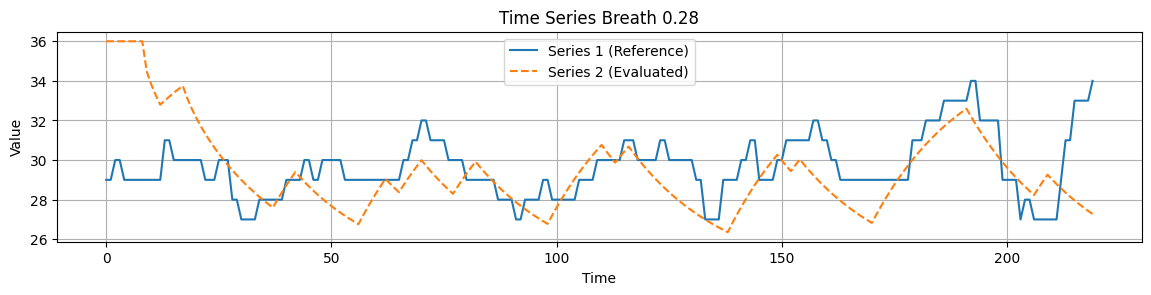

In [10632]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import correlate

# Step 1: Prepare your time series data
# Example data: Simulated time series data
time = np.arange(0, len(breath[EST_START:EST_END]), 1)
series1 = np.array(breath[EST_START:EST_END])  # First time series (e.g., reference signal)
#series2 = np.array(breath_est_paper[EST_START+2:EST_END+2])   # Second time series with a slight shift
#series2 = np.array(breathEstMAF[EST_START+2:EST_END+2])   # Second time series with a slight shift
series2 = np.array(breathEstKalman[EST_START+2:EST_END+2])   # Second time series with a slight shift

# Step 2: Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(series1, series2)
print(f"Pearson Correlation Coefficient: {pearson_corr:.2f}, p-value: {pearson_p:.4f}")

# Step 3: Calculate Cross-Correlation
# Normalized cross-correlation to handle different lengths and scaling
cross_corr = correlate(series1, series2, mode='full', method='auto')
lags = np.arange(-len(series1) + 1, len(series2))

# Find the lag with the maximum correlation
max_corr = np.max(cross_corr)
optimal_lag = lags[np.argmax(cross_corr)]

print(f"Maximum Cross-Correlation: {max_corr:.2f} at Lag: {optimal_lag}")

# Step 4: Plot the Time Series and Cross-Correlation
plt.figure(figsize=(14, 6))

p =int(pearson_corr * 100)

print(p)

# Plot the time series
plt.subplot(2, 1, 1)
plt.plot(time, series1, label='Series 1 (Reference)')
plt.plot(time, series2, label='Series 2 (Evaluated)', linestyle='--')
plt.title(f'Time Series Breath {pearson_corr:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig(f"({EST_TYPE}) Peason breath {PERSON_NUMBER} {p}")

plt.legend()
plt.grid(True)


if 0 == EST_TYPE :
    with open(filename_unwrap_breath ,"a") as file:
        file.write(f"{pearson_corr}\n")
if 1 == EST_TYPE :
    with open(filename_linenear_breath ,"a") as file:
        file.write(f"{pearson_corr}\n")




In [10633]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Step 1: Generate example data for two time series
np.random.seed(0)
time = np.arange(0, len(breath[EST_START:EST_END]), 1)
series1 = np.array(breath[EST_START:EST_END])  # First time series (e.g., reference signal)
#series2 = np.array(breath_est_paper[EST_START+2:EST_END+2])   # Second time series with a slight shift
series2 = np.array(breathEstMAF[EST_START+2:EST_END+2])   # Second time series with a slight shift

# Step 2: Create a combined DataFrame for analysis
data = pd.DataFrame({
    'Time': np.concatenate([time, time]),
    'Value': np.concatenate([series1, series2]),
    'Group': ['Series1'] * len(series1) + ['Series2'] * len(series2)  # Label each group
})

# Step 3: Fit linear regression models separately and visualize them
# plt.figure(figsize=(12, 6))
# plt.scatter(time, series1, alpha=0.5, label='Series 1 (Group 1)')
# plt.scatter(time, series2, alpha=0.5, label='Series 2 (Group 2)')

# # Fit and plot regression lines
# model1 = sm.OLS(series1, sm.add_constant(time)).fit()
# model2 = sm.OLS(series2, sm.add_constant(time)).fit()

# # Plot the regression lines
# plt.plot(time, model1.params[0] + model1.params[1] * time, label='Regression Line 1', color='blue')
# plt.plot(time, model2.params[0] + model2.params[1] * time, label='Regression Line 2', color='red')

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Comparison of Two Regression breath')
# #plt.savefig(f"Regression breath {PERSON_NUMBER}")
# plt.legend()
# plt.grid(True)
# plt.show()

# Step 4: Use ANCOVA to compare the regression lines
# Fit the combined model with interaction to test slope and intercept differences
ancova_model = smf.ols('Value ~ Time * Group', data=data).fit()
# print(ancova_model.summary())


Pearson Correlation Coefficient: -0.09, p-value: 0.2003
Maximum Cross-Correlation: 1791946.19 at Lag: 0


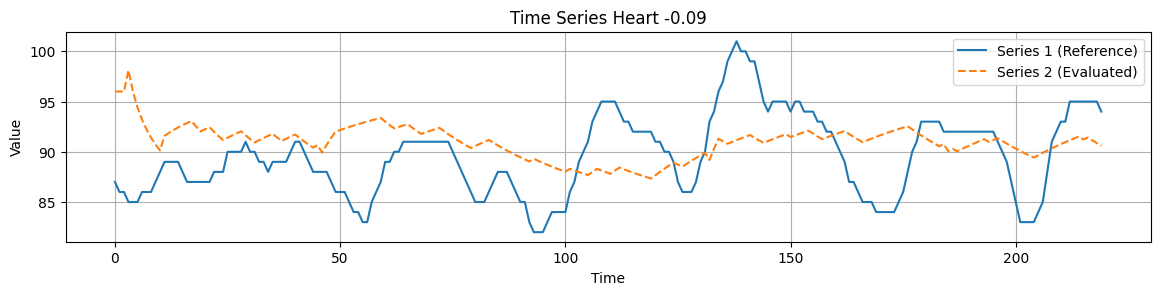

In [10634]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import correlate

# Step 1: Prepare your time series data
# Example data: Simulated time series data
time = np.arange(0, len(heart[EST_START:EST_END]), 1)
series1 = np.array(heart[EST_START:EST_END])  # First time series (e.g., reference signal)
#series2 = np.array(breath_est_paper[EST_START+2:EST_END+2])   # Second time series with a slight shift
# series2 = np.array(heartFreq[EST_START:EST_END])   # Second time series with a slight shift
series2 = np.array(kalmanHeart[EST_START+2:EST_END+2])   # Second time series with a slight shift

# Step 2: Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(series1, series2)
print(f"Pearson Correlation Coefficient: {pearson_corr:.2f}, p-value: {pearson_p:.4f}")

# Step 3: Calculate Cross-Correlation
# Normalized cross-correlation to handle different lengths and scaling
cross_corr = correlate(series1, series2, mode='full', method='auto')
lags = np.arange(-len(series1) + 1, len(series2))

# Find the lag with the maximum correlation
max_corr = np.max(cross_corr)
optimal_lag = lags[np.argmax(cross_corr)]

print(f"Maximum Cross-Correlation: {max_corr:.2f} at Lag: {optimal_lag}")

# Step 4: Plot the Time Series and Cross-Correlation
plt.figure(figsize=(14, 6))
p =int( pearson_corr* 100)
# Plot the time series
plt.subplot(2, 1, 1)
plt.plot(time, series1, label='Series 1 (Reference)')
plt.plot(time, series2, label='Series 2 (Evaluated)', linestyle='--')
plt.title(f'Time Series Heart {pearson_corr:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig(f"({EST_TYPE}) Peason heart {PERSON_NUMBER} {p}")
plt.legend()
plt.grid(True)


if 0 == EST_TYPE :
    with open(filename_unwrap_heart ,"a") as file:
        file.write(f"{pearson_corr}\n")
if 1 == EST_TYPE :
    with open(filename_linenear_heart ,"a") as file:
        file.write(f"{pearson_corr}\n")



In [10635]:
for i in range(1,11):
    PERSON=i
    PERSON_NUMBER=PERSON
    raw_data=raw_datas[PERSON]
    breath_est_paper=breath_est_papers[PERSON]
    heart_est_paper=heart_est_papers[PERSON]
    breath =breaths[PERSON]
    heart =hearts[PERSON]

    BR_LO=np.min(breath)/60
    BR_HI=np.max(breath)/60

    HR_LO=np.min(heart)/60
    HR_HI=np.max(heart)/60
    print(np.min(heart))
    print(np.max(heart))
    EST_WIN_SIZE_HEART=8#10 second
    EST_WIN_SIZE_BREATH=10

    df = pd.read_excel("Participant/Human Data/HumanData.xlsx", header=None)  # assuming no header present
    df_transposed = df.transpose()
    columnNames =[rows[0] for rows in df_transposed.iloc]
    participants =[]
    df_transposed = df.transpose()
    df_transposed = df_transposed[1:]
    for p in range(1,df_transposed.shape[1]):
        participants.append([v for v in df_transposed[p]])

    # participant="Participant #{0},{1},Age={2} month ({3} cms) ({4} kgs)  ({5} bmp) ({6} bmp)".format(PERSON_NUMBER,
    participant="Participant #{0},{1},Age={2} months".format(PERSON_NUMBER,
        participants[PERSON_NUMBER-1][0],participants[PERSON_NUMBER-1][1],
        participants[PERSON_NUMBER-1][2],participants[PERSON_NUMBER-1][3],
        participants[PERSON_NUMBER-1][6],participants[PERSON_NUMBER-1][7])


    print(raw_data.shape)
    estChannel=raw_data[0]
    estChannelLen=len(estChannel)
    print(estChannelLen)
    dataIndex =0
    chirps=[]
    while dataIndex<estChannelLen:
        chirps.append(estChannel[dataIndex:dataIndex+SAMPLE_PER_CHIRP])
        dataIndex +=SAMPLE_PER_CHIRP
    print(np.array(chirps).shape)


    eveluate_channels =[]
    for tmp_channel in  raw_data:
        eveluate_channels.append(np.array([tmp_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)]))

    range_for_plotting =range(1,FFT_SIZE,2**4)
    range_bin_distance =[round(j*RANGE_BIN,2) for j in range_for_plotting ]
    origin_channel=np.array(eveluate_channels[0])


    eliminated_est_channel=np.zeros_like(origin_channel)
    for i in range(0,origin_channel.shape[1]):
        eliminated_est_channel[:,i] =origin_channel[:,i] - np.mean(origin_channel[:,i])


    origin_amplitude =np.abs(np.fft.fft(origin_channel,axis=1))
    eliminated_amplitude =np.abs(np.fft.fft(eliminated_est_channel,axis=1))
   
    sumAmplitude=[]
    for i in range(0,eliminated_amplitude.shape[1]):
        sumAmplitude.append(np.sum(eliminated_amplitude[:,i]))
    binToSelect =np.argmax(sumAmplitude)
   


    est_bin_data=(np.array(origin_channel[:,binToSelect])).flatten()



    est_bin_data_real = [num.real for num in est_bin_data]
    est_bin_data_image =[num.imag for num in est_bin_data]

    # Dữ liệu điểm (x, y)
    x_data_example = np.array(est_bin_data_real)
    y_data_example = np.array(est_bin_data_image)

    # Hàm tính tổng bình phương sai số
    def compute_loss(h, k, r, x, y):
        return np.sum((np.sqrt((x - h) ** 2 + (y - k) ** 2) - r) ** 2)

    # Hàm tính gradient của hàm sai số
    def compute_gradient(h, k, r, x, y):
        n = len(x)
        dL_dh = np.sum(2 * (np.sqrt((x - h) ** 2 + (y - k) ** 2) - r) * (h - x) / np.sqrt((x - h) ** 2 + (y - k) ** 2))
        dL_dk = np.sum(2 * (np.sqrt((x - h) ** 2 + (y - k) ** 2) - r) * (k - y) / np.sqrt((x - h) ** 2 + (y - k) ** 2))
        dL_dr = -2 * np.sum(np.sqrt((x - h) ** 2 + (y - k) ** 2) - r)
        return dL_dh / n, dL_dk / n, dL_dr / n

    # Gradient Descent
    def gradient_descent(x, y, h_init, k_init, r_init, learning_rate=0.01, num_iterations=1000):
        h, k, r = h_init, k_init, r_init
        for i in range(num_iterations):
            # Tính gradient
            dL_dh, dL_dk, dL_dr = compute_gradient(h, k, r, x, y)
            
            # Cập nhật tham số
            h -= learning_rate * dL_dh
            k -= learning_rate * dL_dk
            r -= learning_rate * dL_dr
            
            # In ra giá trị lỗi mỗi 100 lần lặp
            if i % 100 == 0:
                loss = compute_loss(h, k, r, x, y)
                print(f"Iteration {i}, Loss: {loss:.6f}, h: {h:.4f}, k: {k:.4f}, r: {r:.4f}")
        
        return h, k, r

    # Giá trị khởi tạo
    h_init, k_init, r_init = 2.5, 2.0, 1.5

    # Thực hiện gradient descent
    h_opt_gd, k_opt_gd, r_opt_gd = gradient_descent(x_data_example, y_data_example, h_init, k_init, r_init, learning_rate=0.01, num_iterations=1000)

    # Vẽ biểu đồ
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_x = h_opt_gd + r_opt_gd * np.cos(theta)
    circle_y = k_opt_gd + r_opt_gd * np.sin(theta)

    est_gradient_data_compensated=est_bin_data - complex(h_opt_gd,k_opt_gd)
    est_gradient_compensation  =(np.array(est_gradient_data_compensated).flatten()) 
    est_gradient_compensation_real = [num.real for num in est_gradient_compensation]
    est_gradient_compensation_image =[num.imag for num in est_gradient_compensation]


    est_bin_data_compensated=est_bin_data - complex(h_opt_gd,k_opt_gd)

    unwrapped_signal =(np.unwrap(np.angle(est_bin_data)))
    compensated_unwrapped_signal =(np.unwrap(np.angle(est_bin_data_compensated)))

    START_SIGNAL=20
    END_SIGNAL=260


    def estimateFreq(signal_for_est):
        initDuration=5
        sampling_rate=20
        window_size= initDuration*sampling_rate
        
        freq_peaks=[0]*(initDuration-1)
        overlap=20
        start_idx = 0
        while start_idx + window_size <= len(signal_for_est):
            end_idx = start_idx + window_size
            window_signal = signal_for_est[start_idx:end_idx]
            windowFreq=getWindowFreq(window_signal,sampling_rate)
            freq_peaks.append(windowFreq)
            start_idx += overlap
        
        return freq_peaks


    from typing import List

    def kalmanFilter(beatArray:List):
        NOISE_PROCESS =0.08
        npBeat =np.array(beatArray)
        meanBeat=npBeat.mean()
        varianceNoise =np.array([ (beat -meanBeat)**2  for beat in beatArray]).mean()
        errorCovariance=0.0
        lastErrorCovariance =0.5
        estimatedBeat =meanBeat
        for b in beatArray:
            kGain =lastErrorCovariance /(lastErrorCovariance + varianceNoise)
            estimatedBeat =estimatedBeat +kGain *( b-estimatedBeat)
            errorCovariance=(1-kGain)*lastErrorCovariance
            lastErrorCovariance=errorCovariance +NOISE_PROCESS
        return estimatedBeat


    EXTRACT_SAMPLING_RATE=20

    # estimate heart with compensation and without compensation
    breath_signal=filter_signal(compensated_unwrapped_signal,BR_LO,BR_HI,EXTRACT_SAMPLING_RATE,4)
    scales = np.arange(1/BR_HI, 1/BR_LO,1) 
    wavelet = 'morl'  # Complex Morlet wavelet
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(breath_signal, scales, wavelet)
    conditions =(np.where((frequencies >= BR_LO) & (frequencies <=BR_HI)))
    filtered = coefficients[conditions]


    for i in range(0,1):    
        rawBreathFreq =estimateFreq(filtered[i])
        breathEstMAF=moving_average_filter(rawBreathFreq)
        
        breathEstKalman=[]
        for i  in range(START_SIGNAL+1,len(rawBreathFreq)):
            breathEstKalman.append(kalmanFilter(rawBreathFreq[START_SIGNAL:i]))
        for _  in range(0,START_SIGNAL):
            breathEstKalman.insert(0,0)
    
        mape_br=MAPE(breath[START_SIGNAL:END_SIGNAL],breathEstMAF[START_SIGNAL:END_SIGNAL])
        mape_br_paper=MAPE(breath[START_SIGNAL:END_SIGNAL],breath_est_paper[START_SIGNAL:END_SIGNAL])
        mape_br_kalman=MAPE(breath[START_SIGNAL:END_SIGNAL],breathEstKalman[START_SIGNAL:END_SIGNAL])

        rpd_kalmal_br=RPD(breath[START_SIGNAL:END_SIGNAL],breathEstKalman[START_SIGNAL:END_SIGNAL])


    # heart_signal=filter_signal((compensated_unwrapped_signal),HR_LO,HR_HI,EXTRACT_SAMPLING_RATE,2)
    heart_signal=filter_signal((compensated_unwrapped_signal),HR_LO,HR_HI,EXTRACT_SAMPLING_RATE,1)

    scales = np.arange(1/HR_HI, 1/HR_LO,0.1) 
    print(scales)
    wavelet = 'morl'  # Complex Morlet wavelet
    # Perform Continuous Wavelet Transform (CWT)
    heartCoefficients, frequencies = pywt.cwt(heart_signal, scales, wavelet)
    conditions =(np.where((frequencies >= HR_LO) & (frequencies <= HR_HI)))

    # heartFiltered = heartCoefficients[conditions]
    heartFiltered = heartCoefficients


    def estimateHeartFreq(signal_for_est):
        initDuration=5
        sampling_rate=20
        window_size= initDuration*sampling_rate
        
        freq_peaks=[0]*(initDuration-1)
        overlap=20
        start_idx = 0
        while start_idx + window_size <= len(signal_for_est):
            end_idx = start_idx + window_size
            window_signal = signal_for_est[start_idx:end_idx]
            windowFreq=getWindowFreq(window_signal,sampling_rate)
            freq_peaks.append(windowFreq)
            start_idx += overlap
        
        return freq_peaks


    START_SIGNAL=40
    END_SIGNAL=260
    for i in range(1,2):

        rawHeartFreq= estimateHeartFreq(heart_signal)
        heartFreq=moving_average_filter(rawHeartFreq)

        kalmanHeart=[]
        for i  in range(START_SIGNAL+1,len(rawHeartFreq)):
            kalmanHeart.append(kalmanFilter(rawHeartFreq[START_SIGNAL:i]))
        for _  in range(0,START_SIGNAL):
            kalmanHeart.insert(0,0)
    
        mape_hr_kalman=MAPE(heart[START_SIGNAL:END_SIGNAL],kalmanHeart[START_SIGNAL:END_SIGNAL])
        mape_hr_paper=MAPE(heart[START_SIGNAL:END_SIGNAL],heart_est_paper[START_SIGNAL:END_SIGNAL])
        mape_hr=MAPE(heart[START_SIGNAL:END_SIGNAL],heartFreq[START_SIGNAL:END_SIGNAL])
        rpd_hr=RPD(heart[START_SIGNAL:END_SIGNAL],heartFreq[START_SIGNAL:END_SIGNAL])
        print(rpd_hr)

        plt.figure(figsize=(16,4))
        
        plt.plot(kalmanHeart[START_SIGNAL:END_SIGNAL],label=f"HR (Kalman) {mape_hr_kalman}"
                ,color="red",linestyle='-.',linewidth=2)
    
        plt.plot(heartFreq[START_SIGNAL:END_SIGNAL],label=f"HR (MAF) {mape_hr}"
                ,color="red",linestyle='dotted',linewidth=2)

        # plt.plot(heart_est_paper[START_SIGNAL:END_SIGNAL],label=f"HR (PAPER)  {mape_hr_paper}",color="black",linestyle='-.',linewidth=2)
        
        plt.plot(heart[START_SIGNAL:END_SIGNAL],color="red",linestyle='solid',linewidth=3,label="HR (Ref)")
        plt.title(participant)
        plt.ylabel("HR (bpm)")
        plt.xlabel("Time (s)")

        plt.legend()
        #plt.savefig(f"figure_heart {PERSON_NUMBER}")
        plt.show()
        print(participant)
        
        import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr
    from scipy.signal import correlate

    # Step 1: Prepare your time series data
    # Example data: Simulated time series data
    time = np.arange(0, len(breath[EST_START:EST_END]), 1)
    series1 = np.array(breath[EST_START:EST_END])  # First time series (e.g., reference signal)
    #series2 = np.array(breath_est_paper[EST_START+2:EST_END+2])   # Second time series with a slight shift
    series2 = np.array(breathEstKalman[EST_START+2:EST_END+2])   # Second time series with a slight shift

    # Step 2: Calculate Pearson correlation
    pearson_corr, pearson_p = pearsonr(series1, series2)
    print(f"Pearson Correlation Coefficient: {pearson_corr:.2f}, p-value: {pearson_p:.4f}")

    # Step 3: Calculate Cross-Correlation
    # Normalized cross-correlation to handle different lengths and scaling
    cross_corr = correlate(series1, series2, mode='full', method='auto')
    lags = np.arange(-len(series1) + 1, len(series2))

    # Find the lag with the maximum correlation
    max_corr = np.max(cross_corr)
    optimal_lag = lags[np.argmax(cross_corr)]

    print(f"Maximum Cross-Correlation: {max_corr:.2f} at Lag: {optimal_lag}")

    # Step 4: Plot the Time Series and Cross-Correlation
    plt.figure(figsize=(14, 6))

    # Plot the time series
    plt.subplot(2, 1, 1)
    plt.plot(time, series1, label='Series 1 (Reference)')
    plt.plot(time, series2, label='Series 2 (Evaluated)', linestyle='--')
    plt.title(f'Time Series Breath {pearson_corr:.2f}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.savefig(f"Peason breath {PERSON_NUMBER}")

    plt.legend()
    plt.grid(True)
    plt.show()

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    # Step 1: Generate example data for two time series
    np.random.seed(0)
    time = np.arange(0, len(breath[EST_START:EST_END]), 1)
    series1 = np.array(breath[EST_START:EST_END])  # First time series (e.g., reference signal)
    #series2 = np.array(breath_est_paper[EST_START+2:EST_END+2])   # Second time series with a slight shift
    series2 = np.array(breathEstMAF[EST_START+2:EST_END+2])   # Second time series with a slight shift

    # Step 2: Create a combined DataFrame for analysis
    data = pd.DataFrame({
        'Time': np.concatenate([time, time]),
        'Value': np.concatenate([series1, series2]),
        'Group': ['Series1'] * len(series1) + ['Series2'] * len(series2)  # Label each group
    })

    # Step 3: Fit linear regression models separately and visualize them
    plt.figure(figsize=(12, 6))
    plt.scatter(time, series1, alpha=0.5, label='Series 1 (Group 1)')
    plt.scatter(time, series2, alpha=0.5, label='Series 2 (Group 2)')

    # Fit and plot regression lines
    model1 = sm.OLS(series1, sm.add_constant(time)).fit()
    model2 = sm.OLS(series2, sm.add_constant(time)).fit()

    # Plot the regression lines
    plt.plot(time, model1.params[0] + model1.params[1] * time, label='Regression Line 1', color='blue')
    plt.plot(time, model2.params[0] + model2.params[1] * time, label='Regression Line 2', color='red')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Comparison of Two Regression breath')
    #plt.savefig(f"Regression breath {PERSON_NUMBER}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Step 4: Use ANCOVA to compare the regression lines
    # Fit the combined model with interaction to test slope and intercept differences
    ancova_model = smf.ols('Value ~ Time * Group', data=data).fit()
    # print(ancova_model.summary())



In [10658]:
for i in range(1,11):
    PERSON=i
    PERSON_NUMBER=PERSON
    raw_data=raw_datas[PERSON]
    breath_est_paper=breath_est_papers[PERSON]
    heart_est_paper=heart_est_papers[PERSON]
    breath =breaths[PERSON]
    heart =hearts[PERSON]

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr
    from scipy.signal import correlate

    # Step 1: Prepare your time series data
    # Example data: Simulated time series data
    time = np.arange(0, len(breath[EST_START:EST_END]), 1)
    series1 = np.array(breath[EST_START:EST_END])  # First time series (e.g., reference signal)
    series2 = np.array(breath_est_paper[EST_START+2:EST_END+2])   # Second time series with a slight shift

    # Step 2: Calculate Pearson correlation
    breath_pearson_corr, pearson_p = pearsonr(series1, series2)
    print(f"Pearson Correlation Coefficient: {breath_pearson_corr:.2f}, p-value: {pearson_p:.4f}")


    
    # Step 1: Prepare your time series data
    # Example data: Simulated time series data
    time = np.arange(0, len(heart[EST_START:EST_END]), 1)
    series1 = np.array(heart[EST_START:EST_END])  # First time series (e.g., reference signal)
    series2 = np.array(heart_est_paper[EST_START:EST_END])   # Second time series with a slight shift

    # Step 2: Calculate Pearson correlation
    heart_pearson_corr, pearson_p = pearsonr(series1, series2)
    print(f"Pearson Correlation Coefficient: {heart_pearson_corr:.2f}, p-value: {pearson_p:.4f}")

    
    with open(filename_paper_breath ,"a") as file:
        file.write(f"{breath_pearson_corr}\n")
    
    with open(filename_paper__heart ,"a") as file:
        file.write(f"{heart_pearson_corr}\n")



Pearson Correlation Coefficient: 0.03, p-value: 0.6728
Pearson Correlation Coefficient: 0.15, p-value: 0.0286
Pearson Correlation Coefficient: 0.64, p-value: 0.0000
Pearson Correlation Coefficient: -0.23, p-value: 0.0006
Pearson Correlation Coefficient: 0.30, p-value: 0.0000
Pearson Correlation Coefficient: 0.08, p-value: 0.2464
Pearson Correlation Coefficient: 0.62, p-value: 0.0000
Pearson Correlation Coefficient: 0.24, p-value: 0.0003
Pearson Correlation Coefficient: 0.30, p-value: 0.0000
Pearson Correlation Coefficient: 0.18, p-value: 0.0069
Pearson Correlation Coefficient: 0.82, p-value: 0.0000
Pearson Correlation Coefficient: 0.13, p-value: 0.0535
Pearson Correlation Coefficient: 0.48, p-value: 0.0000
Pearson Correlation Coefficient: 0.26, p-value: 0.0001
Pearson Correlation Coefficient: 0.68, p-value: 0.0000
Pearson Correlation Coefficient: 0.23, p-value: 0.0007
Pearson Correlation Coefficient: 0.45, p-value: 0.0000
Pearson Correlation Coefficient: 0.14, p-value: 0.0418
Pearson C

In [10655]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

def FisherZTrans(correlations_method1,correlations_method2,correlations_paper):
   
    # Fisher's Z-transformation function
    def fisher_z_transform(correlations):
        return np.arctanh(correlations)  # Convert Pearson correlations to Z-scores

    # Inverse Fisher's Z-transformation function
    def inverse_fisher_z(z_scores):
        return np.tanh(z_scores)  # Convert Z-scores back to Pearson correlations

    # Apply Fisher Z-transformation to both sets of correlations
    z_method1 = fisher_z_transform(correlations_method1)
    z_method2 = fisher_z_transform(correlations_method2)
    z_paper = fisher_z_transform(correlations_paper)

    # Perform paired t-test to compare the two sets of Fisher Z-transformed correlations
    t_stat, p_value = ttest_rel(z_method1, z_method2)

    # Perform Wilcoxon signed-rank test as a non-parametric alternative
    wilcoxon_stat, wilcoxon_p = wilcoxon(z_method1, z_method2)

    # Compare average correlations (using Fisher Z-transformation and inverse transformation)
    avg_corr_method1 = inverse_fisher_z(np.mean(z_method1))
    avg_corr_method2 = inverse_fisher_z(np.mean(z_method2))
    avg_corr_paper = inverse_fisher_z(np.mean(z_paper))

    print(f"Average Pearson Correlation (Method 1): {avg_corr_method1:.2f}")
    print(f"Average Pearson Correlation (Method 2): {avg_corr_method2:.2f}")
    print(f"Average Pearson Correlation ( Paper): {avg_corr_paper:.2f}")
    
    # print(f"Paired t-test p-value: {p_value:.4f}")
    # print(f"Wilcoxon signed-rank test p-value: {wilcoxon_p:.4f}")


In [10659]:
unwbreaths_corr=[]
with open(filename_unwrap_breath, 'r') as file:
    # unwbreaths_corr = file.read()
    for line in file:
        # Strip the newline character and convert the line to float
        number = float(line.strip())  # .strip() removes \n and any extra whitespace
        # Append the float number to the list
        unwbreaths_corr.append(number)

unwhearts_corr=[]
with open(filename_unwrap_heart, 'r') as file:
    # unwhearts_corr = file.read()
    for line in file:
        # Strip the newline character and convert the line to float
        number = float(line.strip())  # .strip() removes \n and any extra whitespace
        # Append the float number to the list
        unwhearts_corr.append(number)

linebreaths_corr=[]
with open(filename_linenear_breath, 'r') as file:
    #linebreaths_corr = file.read()
    for line in file:
        # Strip the newline character and convert the line to float
        number = float(line.strip())  # .strip() removes \n and any extra whitespace
        # Append the float number to the list
        linebreaths_corr.append(number)
linehearts_corr=[]
with open(filename_linenear_heart, 'r') as file:
    # linehearts_corr = file.read()
    for line in file:
        # Strip the newline character and convert the line to float
        number = float(line.strip())  # .strip() removes \n and any extra whitespace
        # Append the float number to the list
        linehearts_corr.append(number)



paperbreaths_corr=[]
with open(filename_paper_breath, 'r') as file:
    #paperbreaths_corr = file.read()
    for line in file:
        # Strip the newline character and convert the line to float
        number = float(line.strip())  # .strip() removes \n and any extra whitespace
        # Append the float number to the list
        paperbreaths_corr.append(number)

paperhearts_corr=[]
with open(filename_paper__heart, 'r') as file:
    #paperhearts_corr = file.read()
    for line in file:
        # Strip the newline character and convert the line to float
        number = float(line.strip())  # .strip() removes \n and any extra whitespace
        # Append the float number to the list
        paperhearts_corr.append(number)


FisherZTrans(np.array(unwbreaths_corr,dtype=float),np.array(linebreaths_corr,dtype=float),np.array(paperbreaths_corr,dtype=float))
print("\n")
FisherZTrans(unwhearts_corr,linehearts_corr,paperhearts_corr)



Average Pearson Correlation (Method 1): 0.07
Average Pearson Correlation (Method 2): 0.32
Average Pearson Correlation ( Paper): 0.56


Average Pearson Correlation (Method 1): 0.03
Average Pearson Correlation (Method 2): 0.10
Average Pearson Correlation ( Paper): 0.13


In [10661]:

print(type(linebreaths_corr))
# Example Pearson correlation results from 10 samples for two methods
correlations_method1 = np.array(unwbreaths_corr)
correlations_method2 = np.array(linebreaths_corr)


# Fisher's Z-transformation function
def fisher_z_transform(correlations):
    return np.arctanh(correlations)  # Convert Pearson correlations to Z-scores

# Inverse Fisher's Z-transformation function
def inverse_fisher_z(z_scores):
    return np.tanh(z_scores)  # Convert Z-scores back to Pearson correlations

# Apply Fisher Z-transformation to both sets of correlations
z_method1 = fisher_z_transform(correlations_method1)
z_method2 = fisher_z_transform(correlations_method2)

# Perform paired t-test to compare the two sets of Fisher Z-transformed correlations
t_stat, p_value = ttest_rel(z_method1, z_method2)

# Perform Wilcoxon signed-rank test as a non-parametric alternative
wilcoxon_stat, wilcoxon_p = wilcoxon(z_method1, z_method2)

# Compare average correlations (using Fisher Z-transformation and inverse transformation)
avg_corr_method1 = inverse_fisher_z(np.mean(z_method1))
avg_corr_method2 = inverse_fisher_z(np.mean(z_method2))

print(f"Average Pearson Correlation (Method 1): {avg_corr_method1:.2f}")
print(f"Average Pearson Correlation (Method 2): {avg_corr_method2:.2f}")
print(f"Paired t-test p-value: {p_value:.4f}")
print(f"Wilcoxon signed-rank test p-value: {wilcoxon_p:.4f}")


<class 'list'>
Average Pearson Correlation (Method 1): 0.07
Average Pearson Correlation (Method 2): 0.32
Paired t-test p-value: 0.1559
Wilcoxon signed-rank test p-value: 0.3223


In [10662]:
import numpy as np
from scipy.stats import ttest_rel, wilcoxon

# Example Pearson correlation results from 10 samples for two methods
correlations_method1 = np.array([-39.00
,-38.00
,19.00
,-48.00
,23.00
,38.00
,4.00
,47.00
,16.00
,44.00])/100
correlations_method2 = np.array([5.00
,32.00
,4
,76
,23
,35
,39
,34
,20
,28])/100

# Fisher's Z-transformation function
def fisher_z_transform(correlations):
    return np.arctanh(correlations)  # Convert Pearson correlations to Z-scores

# Inverse Fisher's Z-transformation function
def inverse_fisher_z(z_scores):
    return np.tanh(z_scores)  # Convert Z-scores back to Pearson correlations

# Apply Fisher Z-transformation to both sets of correlations
z_method1 = fisher_z_transform(correlations_method1)
z_method2 = fisher_z_transform(correlations_method2)

# Perform paired t-test to compare the two sets of Fisher Z-transformed correlations
t_stat, p_value = ttest_rel(z_method1, z_method2)

# Perform Wilcoxon signed-rank test as a non-parametric alternative
wilcoxon_stat, wilcoxon_p = wilcoxon(z_method1, z_method2)

# Compare average correlations (using Fisher Z-transformation and inverse transformation)
avg_corr_method1 = inverse_fisher_z(np.mean(z_method1))
avg_corr_method2 = inverse_fisher_z(np.mean(z_method2))

print(f"Average Pearson Correlation (Method 1): {avg_corr_method1:.2f}")
print(f"Average Pearson Correlation (Method 2): {avg_corr_method2:.2f}")
print(f"Paired t-test p-value: {p_value:.4f}")
print(f"Wilcoxon signed-rank test p-value: {wilcoxon_p:.4f}")


Average Pearson Correlation (Method 1): 0.07
Average Pearson Correlation (Method 2): 0.32
Paired t-test p-value: 0.1610
Wilcoxon signed-rank test p-value: 0.2604


/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [10663]:
# import numpy as np
# from scipy.stats import ttest_ind, mannwhitneyu

# # Example Pearson correlation results from 10 independent samples for two methods
# # correlations_method1 = np.array([-39.00
# # ,-38.00
# # ,19.00
# # ,-48.00
# # ,23.00
# # ,38.00
# # ,4.00
# # ,47.00
# # ,16.00
# # ,44.00])/100

# correlations_method1 = np.array([5
# ,5
# ,-14
# ,-7
# ,20
# ,-34
# ,-1
# ,27
# ,3
# ,-16])/100


# correlations_method2 = np.array([5.00
# ,32.00
# ,4
# ,76
# ,23
# ,35
# ,39
# ,34
# ,20
# ,28])/100



# # Fisher's Z-transformation function
# def fisher_z_transform(correlations):
#     return np.arctanh(correlations)  # Convert Pearson correlations to Z-scores

# # Inverse Fisher's Z-transformation function
# def inverse_fisher_z(z_scores):
#     return np.tanh(z_scores)  # Convert Z-scores back to Pearson correlations

# # Apply Fisher Z-transformation to both sets of correlations
# z_method1 = fisher_z_transform(correlations_method1)
# z_method2 = fisher_z_transform(correlations_method2)

# # Perform two-sample t-test to compare the two sets of Fisher Z-transformed correlations
# t_stat, p_value = ttest_ind(z_method1, z_method2)

# # Perform Mann-Whitney U test as a non-parametric alternative
# mw_stat, mw_p = mannwhitneyu(z_method1, z_method2)

# # Compare average correlations (using Fisher Z-transformation and inverse transformation)
# avg_corr_method1 = inverse_fisher_z(np.mean(z_method1))
# avg_corr_method2 = inverse_fisher_z(np.mean(z_method2))

# print(f"Average Pearson Correlation (Method 1): {avg_corr_method1:.2f}")
# print(f"Average Pearson Correlation (Method 2): {avg_corr_method2:.2f}")
# print(f"Two-sample t-test p-value: {p_value:.4f}")
# print(f"Mann-Whitney U test p-value: {mw_p:.4f}")
